In [1]:
# Imports
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance

ModuleNotFoundError: No module named 'xgboost'

In [2]:
# Config Settings
TICKER = "SMP"
START_DATE = "2005-01-01"
END_DATE = "2023-06-30"

# label config (you can tweak these)
HORIZON = 5          # days ahead - predicting 15 days into the future
UP_TH = 0.02          # anything thats above this is labelled as 1 for buy (Manually Control the threshold)
DOWN_TH = -0.02       # anything thats below this is labelled as 0 for sell 

# trading / risk config
FEE_RATE = 0.001      # 0.1% per side
BASE_RISK_FRAC = 0.05 # risk max of 5% of account per trade

RANDOM_STATE = 42

In [3]:
df = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=False)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2023-06-23,33.074978,36.090000,36.919998,35.950001,36.529999,173500
2023-06-26,33.432400,36.480000,36.939999,36.099998,36.099998,82200
2023-06-27,34.028095,37.130001,37.250000,36.490002,36.650002,75300
2023-06-28,34.422173,37.560001,37.669998,37.090000,37.150002,55900
2023-06-29,34.697117,37.860001,38.160000,37.410000,37.700001,50800


In [4]:
# Reset index to convert DatetimeIndex to 'Date' column
df = df.reset_index()

# Convert to datetime (If needed, creates a new column 'Date')
df['Date'] = pd.to_datetime(df['Date'])
#df = df[(df['Date'].dt.year >= 2010)].copy()

# Index the dataframe
# !TODO why is this labelled as Price?
df.index = range(len(df))

# Manually set the index to be Index (Its not renaming?) [I think there are two rows in the header, with index being in the second row]
# df.index.name = 'Index' 

df.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
0,2005-01-03,9.236995,15.34,16.00,15.33,15.90,55400
1,2005-01-04,9.230974,15.33,15.62,15.07,15.35,62900
2,2005-01-05,8.875707,14.74,15.24,14.73,15.23,82400
3,2005-01-06,8.749255,14.53,14.91,14.53,14.74,43700
4,2005-01-07,8.520437,14.15,14.55,14.13,14.51,85900


In [5]:
fig = make_subplots(rows=2, cols=1)

# Use OHLC to plot the price
'''
Keep close attention to this, I was previosuly training on Tesla stock, and didn't realize why my return was so low,
Until I plotted it and realized Tesla had a stock boom in 2020
My training was preboom
Validation was postboom
Testing was leveling
'''
fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open, # Open Price
                      high=df.High, # High Price/Top of candle
                      low=df.Low,   # Low Price/Bottom of candle
                      close=df.Close, # Close Price
                      name='Price'), row=1, col=1)

# Plot the volume
'''
Volume is the number of shares traded in a given period.
This can be important to help categorize volatility, and oversold/overbought stocks
'''
fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.show()

In [6]:
'''
# Feature Engineering
def create_features(df):
    df = df.copy()

    #  log returns 
    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))

    #  ATR 
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = (df['High'] - df['Close'].shift(1)).abs()
    df['L-PC'] = (df['Low'] - df['Close'].shift(1)).abs()
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(14).mean()

    #  volatility 
    df['realized_vol_5'] = df['log_returns'].rolling(5).apply(lambda x: np.sqrt(np.mean(x**2)))
    df['realized_vol_20'] = df['log_returns'].rolling(20).apply(lambda x: np.sqrt(np.mean(x**2)))
    df['vol_ratio_5_20'] = df['realized_vol_5'] / df['realized_vol_20']

    #  moving averages & ratios 
    
    # NOTE Remember to shift to prevent lookahead bias
    
    # EMA is similiar to SMA but more weight is given to recent prices (Can be good for volatility)
    df['EMA_9'] = df['Close'].ewm(9).mean().shift()

    df['sma_5'] = df['Close'].rolling(5).mean().shift()
    df['sma_10'] = df['Close'].rolling(10).mean().shift()
    df['sma_20'] = df['Close'].rolling(20).mean().shift()
    df['sma_30'] = df['Close'].rolling(30).mean().shift()

    # MACD 
    
    MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price. 
    The MACD (HERE) is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.
    
    EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
    df['MACD_12_26'] = pd.Series(EMA_12 - EMA_26)
    # NOTE Named it signal_9 even though its using 12_26 to stress that we are using another EMA of 9 to act as a signal line (refernce)
    df['MACD_signal_9'] = pd.Series(df.MACD_12_26.ewm(span=9, min_periods=9).mean())


    df['price_to_sma_5'] = df['Close'] / df['sma_5']
    df['price_to_sma_10'] = df['Close'] / df['sma_10']
    df['price_to_sma_20'] = df['Close'] / df['sma_20']

    #  SMA slopes 
    def slope(series):
        y = series.values
        x = np.arange(len(y))
        if len(y) < 2 or np.isnan(y).any():
            return np.nan
        return np.polyfit(x, y, 1)[0]

    df['sma_slope_5'] = df['Close'].rolling(5).apply(slope, raw=False)
    df['sma_slope_10'] = df['Close'].rolling(10).apply(slope, raw=False)
    df['sma_slope_20'] = df['Close'].rolling(20).apply(slope, raw=False)

    # mentum 
    df['momentum_5'] = df['Close'].pct_change(5)
    df['momentum_10'] = df['Close'].pct_change(10)

    #  RSI 
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    RS = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + RS))

    #  Stochastics 
    low14 = df['Low'].rolling(14).min()
    high14 = df['High'].rolling(14).max()
    df['Stoch_K'] = 100 * (df['Close'] - low14) / (high14 - low14)
    df['Stoch_D'] = df['Stoch_K'].rolling(3).mean()

    #  volume 
    df['Volume_zscore'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df['OBV_roc'] = df['OBV'].pct_change()

    #  candlesticks 
    df['real_body'] = (df['Close'] - df['Open']).abs()
    df['upper_shadow'] = df['High'] - np.maximum(df['Close'], df['Open'])
    df['lower_shadow'] = np.minimum(df['Close'], df['Open']) - df['Low']
    df['body_to_range'] = df['real_body'] / (df['High'] - df['Low'])

    #  misc 
    df['High_Low_range'] = df['High'] - df['Low']

    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    return df
'''


"\n# Feature Engineering\ndef create_features(df):\n    df = df.copy()\n\n    # --- log returns ---\n    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))\n\n    # --- ATR ---\n    df['H-L'] = df['High'] - df['Low']\n    df['H-PC'] = (df['High'] - df['Close'].shift(1)).abs()\n    df['L-PC'] = (df['Low'] - df['Close'].shift(1)).abs()\n    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)\n    df['ATR'] = df['TR'].rolling(14).mean()\n\n    # --- volatility ---\n    df['realized_vol_5'] = df['log_returns'].rolling(5).apply(lambda x: np.sqrt(np.mean(x**2)))\n    df['realized_vol_20'] = df['log_returns'].rolling(20).apply(lambda x: np.sqrt(np.mean(x**2)))\n    df['vol_ratio_5_20'] = df['realized_vol_5'] / df['realized_vol_20']\n\n    # --- moving averages & ratios ---\n\n    # NOTE Remember to shift to prevent lookahead bias\n\n    # EMA is similiar to SMA but more weight is given to recent prices (Can be good for volatility)\n    df['EMA_9'] = df['Close'].ewm(9).mean().shift(

In [7]:
# Features
from utils_optimized import create_features

data = create_features(df)
data.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume,H-L,H-PC,L-PC,...,sma_5,sma_10,sma_30,sma_50,sma_slope_20,sma_slope_30,OBV,momentum_30,MACD_12_26,MACD_signal_9
50,2005-03-16,7.041229,11.61,11.74,11.60,11.60,23600,0.139999,0.130000,0.009999,...,11.59,11.546,12.110000,12.6786,-0.037233,-0.059673,-558700.0,-0.092969,-0.251828,-0.303538
51,2005-03-17,7.132203,11.76,11.83,11.64,11.66,25200,0.190000,0.220000,0.030001,...,11.61,11.554,12.070333,12.6040,-0.022647,-0.056643,-533500.0,-0.081250,-0.223800,-0.287552
52,2005-03-18,7.132203,11.76,11.85,11.15,11.85,191400,0.700001,0.090000,0.610001,...,11.66,11.584,12.035667,12.5326,-0.010429,-0.053840,-533500.0,-0.074016,-0.199289,-0.269865
53,2005-03-21,7.101876,11.71,11.82,11.61,11.82,42300,0.210000,0.059999,0.150001,...,11.69,11.610,12.004333,12.4730,0.000729,-0.049976,-575800.0,-0.088006,-0.181744,-0.252213
54,2005-03-22,7.035164,11.60,11.75,11.55,11.70,53600,0.200000,0.040000,0.160000,...,11.69,11.630,11.966667,12.4166,0.006609,-0.044111,-629400.0,-0.118541,-0.174581,-0.236668


In [8]:
'''
for col in data.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(data[col])
    plt.title(col)
    plt.show()
'''
'''
NOTE The lines are of different scales, so we need to normalize them
fig = go.Figure()
# Exclude Index and Date
for col in data.columns[2:]:
    if col in ["OBV", "Volume"]:
        continue
    fig.add_trace(go.Scatter(x=data.Date, y=data[col], name=col))
fig.show()
'''

# Plotting all the features together kinda sucks, so we'll just plot the important ones
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=('SMAs with Close Price', 'Momentum', 'Volatility', 'RSI'),
    vertical_spacing=0.08,
    row_heights=[0.3, 0.25, 0.25, 0.2]  # Make first plot larger
)

# Plot 1: SMAs with Close Price
if 'Close' in data.columns:
    fig.add_trace(
        go.Scatter(x=data.Date, y=data['Close'], name='Close', 
                   line=dict(color='black', width=2), opacity=0.7),
        row=1, col=1
    )

sma_cols = ['sma_5', 'sma_10', 'sma_20']
sma_colors = ['red', 'blue', 'green']
sma_names = ['SMA 5', 'SMA 10', 'SMA 20']

for col, color, name in zip(sma_cols, sma_colors, sma_names):
    if col in data.columns:
        plot_data = data[[col, 'Date']].dropna()
        if len(plot_data) > 0:
            fig.add_trace(
                go.Scatter(x=plot_data.Date, y=plot_data[col], name=name,
                          line=dict(color=color, width=1.5)),
                row=1, col=1
            )

# Plot 2: Momentum
momentum_cols = ['momentum_5', 'momentum_10']
momentum_colors = ['purple', 'orange']
momentum_names = ['Momentum 5', 'Momentum 10']

for col, color, name in zip(momentum_cols, momentum_colors, momentum_names):
    if col in data.columns:
        plot_data = data[[col, 'Date']].dropna()
        if len(plot_data) > 0:
            fig.add_trace(
                go.Scatter(x=plot_data.Date, y=plot_data[col], name=name,
                          line=dict(color=color, width=1.5)),
                row=2, col=1
            )

# Add zero line for momentum
fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5, row=2, col=1)

# Plot 3: Volatility
vol_cols = ['realized_vol_5', 'realized_vol_20']
vol_colors = ['darkred', 'darkblue']
vol_names = ['Volatility 5', 'Volatility 20']

for col, color, name in zip(vol_cols, vol_colors, vol_names):
    if col in data.columns:
        plot_data = data[[col, 'Date']].dropna()
        if len(plot_data) > 0:
            fig.add_trace(
                go.Scatter(x=plot_data.Date, y=plot_data[col], name=name,
                          line=dict(color=color, width=1.5)),
                row=3, col=1
            )

# Plot 4: RSI
if 'RSI' in data.columns:
    rsi_data = data[['RSI', 'Date']].dropna()
    if len(rsi_data) > 0:
        fig.add_trace(
            go.Scatter(x=rsi_data.Date, y=rsi_data['RSI'], name='RSI',
                      line=dict(color='darkgreen', width=2)),
            row=4, col=1
        )
    
    # Add RSI overbought/oversold lines
    fig.add_hline(y=70, line_dash="dash", line_color="red", 
                  annotation_text="Overbought (70)", row=4, col=1)
    fig.add_hline(y=30, line_dash="dash", line_color="green", 
                  annotation_text="Oversold (30)", row=4, col=1)
    fig.add_hline(y=50, line_dash="dot", line_color="gray", opacity=0.5, row=4, col=1)

# Update axes labels
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Price ($)", row=1, col=1)
fig.update_yaxes(title_text="Momentum", row=2, col=1)
fig.update_yaxes(title_text="Volatility", row=3, col=1)
fig.update_yaxes(title_text="RSI", row=4, col=1)

# Set RSI y-axis range
fig.update_yaxes(range=[0, 100], row=4, col=1)

# Update layout
fig.update_layout(
    height=1200,
    title_text="Technical Indicators: SMAs, Momentum, Volatility, and RSI",
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()

In [9]:
from sklearn.model_selection import train_test_split

# 85% for train+valid, 15% for test
test_size = 0.15
valid_size = 0.15

train_valid_df, test_df = train_test_split(data, test_size=test_size, shuffle=False)

# Second split: separate validation from training
# From the 85%, take 15% for validation
valid_size_adjusted = valid_size / (1 - test_size)

# Don't shuffle for time series
train_df, valid_df = train_test_split(train_valid_df,test_size=valid_size_adjusted,shuffle=False)

In [10]:
train_df.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume,H-L,H-PC,L-PC,...,sma_5,sma_10,sma_30,sma_50,sma_slope_20,sma_slope_30,OBV,momentum_30,MACD_12_26,MACD_signal_9
50,2005-03-16,7.041229,11.61,11.74,11.60,11.60,23600,0.139999,0.130000,0.009999,...,11.59,11.546,12.110000,12.6786,-0.037233,-0.059673,-558700.0,-0.092969,-0.251828,-0.303538
51,2005-03-17,7.132203,11.76,11.83,11.64,11.66,25200,0.190000,0.220000,0.030001,...,11.61,11.554,12.070333,12.6040,-0.022647,-0.056643,-533500.0,-0.081250,-0.223800,-0.287552
52,2005-03-18,7.132203,11.76,11.85,11.15,11.85,191400,0.700001,0.090000,0.610001,...,11.66,11.584,12.035667,12.5326,-0.010429,-0.053840,-533500.0,-0.074016,-0.199289,-0.269865
53,2005-03-21,7.101876,11.71,11.82,11.61,11.82,42300,0.210000,0.059999,0.150001,...,11.69,11.610,12.004333,12.4730,0.000729,-0.049976,-575800.0,-0.088006,-0.181744,-0.252213
54,2005-03-22,7.035164,11.60,11.75,11.55,11.70,53600,0.200000,0.040000,0.160000,...,11.69,11.630,11.966667,12.4166,0.006609,-0.044111,-629400.0,-0.118541,-0.174581,-0.236668


In [11]:
# Visualization
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date, y=test_df.Close, name='Test'))
fig.show()

In [12]:
''' This uses the Close price as the target variable, but I am experimenting with using log returns as the target variable


# First, extract the target variable BEFORE dropping columns
# Shift target forward by HORIZON days to predict future price
y_train = train_df['Close'].shift(-HORIZON).copy()
y_valid = valid_df['Close'].shift(-HORIZON).copy()
y_test  = test_df['Close'].shift(-HORIZON).copy()

# Then drop columns (including Close and Adj Close) from features
# We don't need "Date" for timeseries, because Onehot encoding won't give any temporal information to Random Forest
# The order of the rows will represent the time series (Don't Shuffle anywhere)
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Close', 'Adj Close']

# Only drop columns that exist (Had some issues when different datasets didn't have columns named a certain way so I just put variations of the names and let this handle it)
drop_cols = [col for col in drop_cols if col in train_df.columns]

X_train = train_df.drop(columns=drop_cols)
X_valid = valid_df.drop(columns=drop_cols)
X_test  = test_df.drop(columns=drop_cols)

# Drop the last HORIZON rows from both X and y to remove NaN targets
# (The last HORIZON rows don't have future prices to predict)
X_train = X_train.iloc[:-HORIZON].copy()
y_train = y_train.iloc[:-HORIZON].copy()

X_valid = X_valid.iloc[:-HORIZON].copy()
y_valid = y_valid.iloc[:-HORIZON].copy()

X_test = X_test.iloc[:-HORIZON].copy()
y_test = y_test.iloc[:-HORIZON].copy()

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")

'''

' This uses the Close price as the target variable, but I am experimenting with using log returns as the target variable\n\n\n# First, extract the target variable BEFORE dropping columns\n# Shift target forward by HORIZON days to predict future price\ny_train = train_df[\'Close\'].shift(-HORIZON).copy()\ny_valid = valid_df[\'Close\'].shift(-HORIZON).copy()\ny_test  = test_df[\'Close\'].shift(-HORIZON).copy()\n\n# Then drop columns (including Close and Adj Close) from features\n# We don\'t need "Date" for timeseries, because Onehot encoding won\'t give any temporal information to Random Forest\n# The order of the rows will represent the time series (Don\'t Shuffle anywhere)\ndrop_cols = [\'Date\', \'Volume\', \'Open\', \'Low\', \'High\', \'Close\', \'Adj Close\']\n\n# Only drop columns that exist (Had some issues when different datasets didn\'t have columns named a certain way so I just put variations of the names and let this handle it)\ndrop_cols = [col for col in drop_cols if col in 

In [13]:
# Use log returns as the target variable
y_train = np.log(train_df['Close'].shift(-HORIZON) / train_df['Close'])
y_valid = np.log(valid_df['Close'].shift(-HORIZON) / valid_df['Close'])
y_test  = np.log(test_df['Close'].shift(-HORIZON) / test_df['Close'])

drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Close', 'Adj Close']
drop_cols = [col for col in drop_cols if col in train_df.columns]

X_train = train_df.drop(columns=drop_cols)
X_valid = valid_df.drop(columns=drop_cols)
X_test  = test_df.drop(columns=drop_cols)

# Remove last HORIZON rows 
X_train = X_train.iloc[:-HORIZON].copy()
y_train = y_train.iloc[:-HORIZON].copy()

X_valid = X_valid.iloc[:-HORIZON].copy()
y_valid = y_valid.iloc[:-HORIZON].copy()

X_test = X_test.iloc[:-HORIZON].copy()
y_test = y_test.iloc[:-HORIZON].copy()

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 3217 samples
Validation set: 686 samples
Test set: 686 samples


In [14]:
# Grid Search best params for XGBoost
# TO ensure that k-fold cross validation is done in a time series manner, we use TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit


params = {
    'n_estimators': 300,
    'learning_rate': 0.01,
    'max_depth': 8,
    'random_state': 42,
    'objective': 'reg:squarederror',
    'n_jobs': -1
}

model = xgb.XGBRegressor(**params)
eval_set = [(X_train, y_train), (X_valid, y_valid)]

model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False  
)


'''
# TO ensure that k-fold cross validation is done in a time series manner, we use TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
clf = GridSearchCV(
    model, 
    parameters, 
    cv=tscv,                            # Use time series split
    scoring='neg_mean_squared_error',   # Use MSE (minimize error)
    verbose=1
)
clf.fit(X_train, y_train)
print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')
'''

"\n# TO ensure that k-fold cross validation is done in a time series manner, we use TimeSeriesSplit\nfrom sklearn.model_selection import TimeSeriesSplit\ntscv = TimeSeriesSplit(n_splits=5)\nclf = GridSearchCV(\n    model, \n    parameters, \n    cv=tscv,                            # Use time series split\n    scoring='neg_mean_squared_error',   # Use MSE (minimize error)\n    verbose=1\n)\nclf.fit(X_train, y_train)\nprint(f'Best params: {clf.best_params_}')\nprint(f'Best validation score = {clf.best_score_}')\n"

In [15]:
from sklearn.metrics import mean_squared_error, r2_score

preds = model.predict(X_valid)
mse = mean_squared_error(y_valid, preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, preds)


# Decided to manually test the model, as using K-Fold Cross Validation and destroying the time series nature of the data was heavily affecting the performance
print(f"\nValidation Results:")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


Validation Results:
RMSE: 0.0467
R2 Score: -0.0513


In [16]:
'''
# Fit the model with best params
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
'''

"\n# Fit the model with best params\nmodel = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')\nmodel.fit(X_train, y_train, eval_set=eval_set, verbose=False)\n"

<Figure size 1500x2000 with 0 Axes>

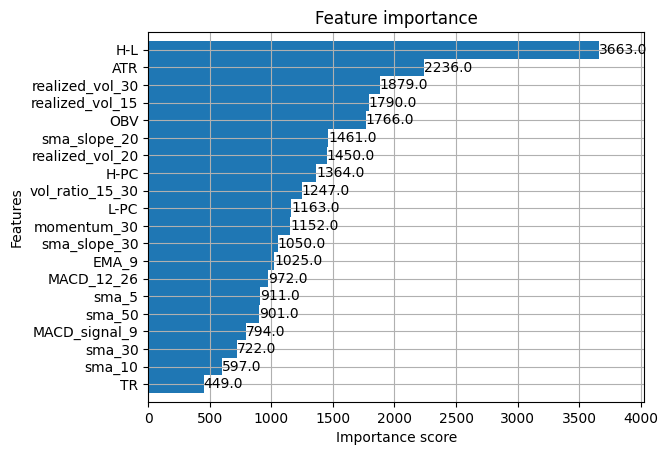

In [17]:
# Adjust the figure size
plt.figure(figsize=(15, 20))  # Width=15, Height=20 (Increase height for more features)
plot_importance(model, max_num_features=20, height=1) # Show top 50 features
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

# ===============================
# BASELINE for LOG RETURNS
# ===============================
baseline_pred = np.zeros_like(y_valid)   # predict 0 future return
baseline_rmse = np.sqrt(mean_squared_error(y_valid, baseline_pred))
baseline_r2   = r2_score(y_valid, baseline_pred)

# ===============================
# MODEL PERFORMANCE
# ===============================
model_pred = preds
model_rmse = np.sqrt(mean_squared_error(y_valid, model_pred))
model_r2   = r2_score(y_valid, model_pred)

print(f"=== HORIZON = {HORIZON} DAYS ===")
print("MODEL:")
print(f" RMSE: {model_rmse:.4f}")
print(f" R2:   {model_r2:.4f}")

print("\nBASELINE (predict return = 0):")
print(f" RMSE: {baseline_rmse:.4f}")
print(f" R2:   {baseline_r2:.4f}")

if model_rmse < baseline_rmse:
    print("\n model beats the baseline ✔")
else:
    print("\n model does NOT beat the baseline ✘")


=== HORIZON = 5 DAYS ===
MODEL:
 RMSE: 0.0467
 R2:   -0.0513

BASELINE (predict return = 0):
 RMSE: 0.0455
 R2:   -0.0001

 model does NOT beat the baseline ✘


=== HORIZON = 5 DAYS ===
MODEL:
 RMSE: 0.0446
 R2:   0.0285

BASELINE (predict return = 0):
 RMSE: 0.0452
 R2:   -0.0001

 model beats the baseline ✔


=== HORIZON = 10 DAYS ===
MODEL:
 RMSE: 0.0608
 R2:   0.0289

BASELINE (predict return = 0):
 RMSE: 0.0618
 R2:   -0.0008

 model beats the baseline ✔

=== HORIZON = 20 DAYS ===
MODEL:
 RMSE: 0.0771
 R2:   -0.2782

BASELINE (predict return = 0):
 RMSE: 0.0683
 R2:   -0.0040

 model does NOT beat the baseline ✘


=== HORIZON = 30 DAYS ===
MODEL:
 RMSE: 0.0858
 R2:   -0.0126

BASELINE (predict return = 0):
 RMSE: 0.0856
 R2:   -0.0089

 model does NOT beat the baseline ✘



Performs amazing at 5 and 10 days, real predicitve power (most finanical predictions have difficulty with longer periods due to noise, and I haven't had long term noise as a consideration as I am looking towards short term predictions)

In [28]:
%matplotlib notebook

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# =========================================
# 1. LOAD MICROSOFT LOG-PRICE DATA
# =========================================
msft = yf.download("MSFT", start="2022-01-01", end="2025-01-01")
msft["log_price"] = np.log(msft["Close"])

# Future log return for your HORIZON
msft["log_return_fut"] = msft["log_price"].shift(-HORIZON) - msft["log_price"]

# Drop NaNs at the end horizon
msft = msft.dropna()

# ALIGN MODEL'S PREDICTIONS TO MSFT

# Your predictions correspond to y_valid
# So index them to the last len(y_valid) timestamps of MSFT
y_valid_series  = pd.Series(y_valid,  index=msft.index[-len(y_valid):])
preds_series    = pd.Series(preds,     index=msft.index[-len(preds):])

# METRICS — LOG RETURNS ONLY
baseline_pred = np.zeros_like(y_valid)

baseline_rmse = np.sqrt(mean_squared_error(y_valid, baseline_pred))
baseline_r2   = r2_score(y_valid, baseline_pred)

model_rmse = np.sqrt(mean_squared_error(y_valid, preds))
model_r2   = r2_score(y_valid, preds)

print(f"=== MICROSOFT TEST — HORIZON = {HORIZON} DAYS ===")
print("MODEL:")
print(f" RMSE: {model_rmse:.4f}")
print(f" R2:   {model_r2:.4f}")

print("\nBASELINE (predict 0 future log-return):")
print(f" RMSE: {baseline_rmse:.4f}")
print(f" R2:   {baseline_r2:.4f}")

print("\n✔ Model beats baseline" if model_rmse < baseline_rmse 
      else "\n✘ Model does NOT beat baseline")

# VISUALIZE PREDICTIONS ON LOG PRICE
import plotly.graph_objs as go

fig = go.Figure()

# True log price
fig.add_trace(go.Scatter(
    x=msft.index,
    y=msft["log_price"],
    mode="lines",
    name="Log Price (MSFT)"
))

# Predicted overlay
overlay = msft["log_price"].loc[preds_series.index] + preds_series
fig.add_trace(go.Scatter(
    x=overlay.index,
    y=overlay,
    mode="lines",
    name="Predicted Overlay",
    line=dict(color='red')
))

fig.update_layout(
    title="MSFT Log Price with Future Log-Return Prediction Overlay",
    xaxis_title="Year",
    yaxis_title="Log Price",
    hovermode="x unified"
)

fig.show()

plt.show()


C:\Users\ahmad\AppData\Local\Temp\ipykernel_5512\583034504.py:12: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

=== MICROSOFT TEST — HORIZON = 5 DAYS ===
MODEL:
 RMSE: 0.0467
 R2:   -0.0513

BASELINE (predict 0 future log-return):
 RMSE: 0.0455
 R2:   -0.0001

✘ Model does NOT beat baseline
